MCCS PI21 Demo 

Versions:
- ska-low-mccs (OCI_IMAGE)  : ""
- ska-low-mccs (helm chart) : ""

Target platform:
- AAVS3

Demo Overview:
- Section1: Power Cycle MCCS 
- Section2: Trigger ADC equalisation
- Section3: Execute a Scan

In [1]:
# import subprocess
# subprocess.call(['pip', 'install', 'astropy'])

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
from ska_control_model import ObsState
import time
from astropy.time import Time,TimeDelta
from astropy.coordinates import AltAz, Angle, EarthLocation, SkyCoord, get_sun, get_moon
# import pydaq
from utils.daq_data_parsers import StationBeamDataFile
from utils.utils import display_adc, configure_daq_for_station_beam_monitoring, display_antenna_powers, move_obsstate_to_empty, display_tile_attributes, wait_for_obsstate, wait_for_lrcs_to_finish, point_subarray, route_traffic_to_daq, configure_daq_for_bandpass_monitoring, print_allocated_resources

In [2]:
import tango
db = tango.Database()

Form proxies to the devices needed in the notebook.
NOTE: device names may change depending on the platform.
try:
all_devices_strings = db.get_device_exported("low-mccs/*")
print(all_devices_strings)
to see all mccs devices present in cluster.

In [3]:

# SPSHW devices
tiles = [tango.DeviceProxy(f"low-mccs/tile/aavs3-tpm{i:02d}") for i in range(1,17)]
subracks = [tango.DeviceProxy(f"low-mccs/subrack/aavs3-sr{i:01d}") for i in range(1,3)]
calibration_store = tango.DeviceProxy("low-mccs/calibrationstore/aavs3")
spsstation = tango.DeviceProxy("low-mccs/spsstation/aavs3")
daq = tango.DeviceProxy("low-mccs/daqreceiver/aavs3")

# PaSD devices
pasdbus = tango.DeviceProxy("low-mccs/pasdbus/aavs3")
smartboxes = [tango.DeviceProxy(f"low-mccs/smartbox/aavs3-sb{i:02d}") for i in range(1,25)]
fndh = tango.DeviceProxy("low-mccs/fndh/aavs3")
fieldstation = tango.DeviceProxy("low-mccs/fieldstation/aavs3")

# MCCS devices
station = tango.DeviceProxy("low-mccs/station/aavs3")
controller = tango.DeviceProxy("low-mccs/control/control")

beam_device_strings = db.get_device_exported("low-mccs/beam/*")
station_beams = [tango.DeviceProxy(device_str) for device_str in beam_device_strings]

subarray = tango.DeviceProxy("low-mccs/subarray/01")

subarray_beams = [tango.DeviceProxy("low-mccs/subarraybeam/01")]


devices_with_lrc_to_watch = [subarray] + subarray_beams + station_beams + [station]

Turn All devices ONLINE is not already.

In [5]:
all_devices_strings = db.get_device_exported("low-mccs/*")
mccs_devices = []

for device_str in all_devices_strings:
    try:
        device = tango.DeviceProxy(device_str)
        mccs_devices.append(device)
        if not device.adminMode == 0:
            try:
                device.adminMode = 0
            except Exception:
                print(f"Exception raised for {device.dev_name()}, Unable to turn ONLINE")
    except Exception:
        print(f"Exception raised for {device_str}, Unable to turn form Proxy")

Exception raised for low-mccs/mockfieldstation/aavs3, Unable to turn form Proxy


In [6]:
# Turn Everything off
controller.Off()

[array([2], dtype=int32), ['1712548653.9301975_230911490191180_Off']]

In [7]:
display_tile_attributes(tiles, *['state', 'stationId', 'logicalTileId', 'tileProgrammingState'])

state                                          stationId  \
0    OFF                                                  1   
1    OFF  DevFailed(args = (DevError(desc = "ConnectionE...   
2    OFF                                                  1   
3    OFF  DevFailed(args = (DevError(desc = "ConnectionE...   
4    OFF  DevFailed(args = (DevError(desc = "ConnectionE...   
5    OFF                                                  1   
6    OFF  DevFailed(args = (DevError(desc = "ConnectionE...   
7    OFF  DevFailed(args = (DevError(desc = "ConnectionE...   
8    OFF  DevFailed(args = (DevError(desc = "ConnectionE...   
9    OFF  DevFailed(args = (DevError(desc = "ConnectionE...   
10   OFF  DevFailed(args = (DevError(desc = "ConnectionE...   
11   OFF  DevFailed(args = (DevError(desc = "ConnectionE...   
12   OFF                                                  1   
13   OFF  DevFailed(args = (DevError(desc = "ConnectionE...   
14   OFF                                                  1   
15   OFF                                                  1   

                                        logicalTileId tileProgrammingState  
0                                                   0                  Off  
1   DevFailed(args = (DevError(desc = "ConnectionE...                  Off  
2                                                   2                  Off  
3   DevFailed(args = (DevError(desc = "ConnectionE...                  Off  
4   DevFailed(args = (DevError(desc = "ConnectionE...                  Off  
5                                                   5                  Off  
6   DevFailed(args = (DevError(desc = "ConnectionE...                  Off  
7   DevFailed(args = (DevError(desc = "ConnectionE...                  Off  
8   DevFailed(args = (DevError(desc = "ConnectionE...                  Off  
9   DevFailed(args = (DevError(desc = "ConnectionE...                  Off  
10  DevFailed(args = (DevError(desc = "ConnectionE...                  Off  
11  DevFailed(args = (DevError(desc = "ConnectionE...                  Off  
12                                                 12                  Off  
13  DevFailed(args = (DevError(desc = "ConnectionE...                  Off  
14                                                 14                  Off  
15                                                 15                  Off

In [8]:
display_antenna_powers(fieldstation)

In [53]:
controller.On()

[array([2], dtype=int32), ['1715263497.505637_118228341958062_On']]

In [39]:
display_tile_attributes(tiles, *['state', 'stationId', 'logicalTileId', 'tileProgrammingState'])

state  stationId  logicalTileId tileProgrammingState
0     ON          1              0          Initialised
1     ON          1              1          Initialised
2     ON          1              2          Initialised
3     ON          1              3          Initialised
4     ON          1              4          Initialised
5     ON          1              5          Initialised
6     ON          1              6          Initialised
7     ON          1              7          Initialised
8     ON          1              8          Initialised
9     ON          1              9          Initialised
10    ON          1             10          Initialised
11    ON          1             11          Initialised
12    ON          1             12          Initialised
13    ON          1             13          Initialised
14    ON          1             14          Initialised
15    ON          1             15          Initialised

In [56]:
display_antenna_powers(fieldstation)

In [13]:
# +++++++++++++++++++++++++++++++++++++++++++++(Step 2: Trigger ADC equalisation.)+++++++++++=++++++++++++++++++++++++++++++




In [57]:
daq_status = json.loads(daq.DaqStatus())
tpm_config = {
    "mode": "10G",
    "destination_ip": daq_status["Receiver IP"][0],
    "destination_port": daq_status["Receiver Ports"][0],
    "channel_payload_length": 8192,
}
spsstation.SetLmcDownload(json.dumps(tpm_config))
spsstation.SetCspIngest(json.dumps(tpm_config))

[array([0], dtype=int32), ['SetCspIngest command completed OK']]

In [34]:
[task_status],[command_id]= spsstation.initialise()

In [ ]:
spsstation.checklongrunningcommandstatus(command_id)

In [46]:
spsstation.StartAcquisition("{}")

[array([2], dtype=int32),
 ['1715280605.7972744_166762309834028_StartAcquisition']]

In [65]:
# Muddle the ADC levels by setting PreADU levels constant.
spsstation.preadulevels=[24]*512

In [72]:
display_adc(tiles)

In [73]:
[_], [command_id] = spsstation.TriggerAdcEqualisation()

In [79]:
# Aim for 17
display_adc(tiles)

In [24]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++ (STEP 3: Bandpass plot) +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




In [122]:
daq.stop()

[array([0], dtype=int32), ['Daq stopped']]

In [123]:
# (daq_tango_device, plot_directory)
configure_daq_for_bandpass_monitoring(daq, "/product/aavs3/acquisition-2024-19-02/pi21-demo")

In [124]:
# (spsstation_tango_device, daq_tango_device)
route_traffic_to_daq(spsstation, daq)

In [134]:
spsstation.StopDataTransmission()

[array([0], dtype=int32), ['SetCspIngest command completed OK']]

In [129]:
spsstation.ConfigureIntegratedChannelData('{"integration_time": 5.0}')

[array([0], dtype=int32),
 ['ConfigureIntegratedChannelData command completed OK']]

In [127]:
daq.StartBandpassMonitor(json.dumps({"plot_directory": "/product/aavs3/acquisition-2024-19-02/pi21-demo"}))
# This will dump .svg files to a location aavs3/acquisition-2024-19-02/pi21-demo/a_station_name from mounted volume.

[array([2], dtype=int32),
 ['1715268770.1415339_78984124602745_StartBandpassMonitor']]

In [121]:
daq.StopBandpassMonitor()

[array([0], dtype=int32), ['Bandpass monitor stopping.']]

In [109]:
daq.GetConfiguration()

'{"nof_antennas": 16, "nof_channels": 512, "nof_beams": 1, "nof_polarisations": 2, "nof_tiles": 16, "nof_raw_samples": 32768, "raw_rms_threshold": -1, "nof_channel_samples": 1024, "nof_correlator_samples": 1835008, "nof_correlator_channels": 1, "nof_beam_samples": 42, "nof_beam_channels": 384, "nof_station_samples": 262144, "receiver_frames_per_block": 32, "receiver_nof_blocks": 256, "receiver_nof_threads": 1, "receiver_frame_size": 8500, "acquisition_duration": -1, "acquisition_start_time": -1, "append_integrated": true, "logging": true, "write_to_disk": true, "sampling_time": 1.1325, "sampling_rate": 925925.9259259258, "oversampling_factor": 1.1851851851851851, "receiver_ports": "[4660]", "observation_metadata": "{\'software_version\': 0, \'description\': \'\'}", "receiver_interface": "net1", "receiver_ip": "10.137.0.110", "directory": "/product/eb-t0001-20240506-00001/ska-low-mccs/38/"}'

In [10]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++(Step 4)++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Allocate 
# Configure 
# Scan

In [247]:
# Check cleaned
daq.daqStatus()

'{"Running Consumers": [], "Receiver Interface": "net1", "Receiver Ports": [4660], "Receiver IP": ["10.137.0.110"], "Bandpass Monitor": false, "Daq Health": ["OK", 0]}'

In [94]:
# Check if we have any allocated resources in cluster pre-existing
print_allocated_resources(controller, subarray)

Controller resources allocated to subarray: {}
Subarray resources
- Stations:       ()
- Subarray beams: ()
- Station beams:  ()
- All assigned resources: {'interface': 'https://schema.skao.int/ska-low-mccs-assignedresources/1.0', 'subarray_beam_ids': [], 'station_beam_ids': [], 'station_ids': [], 'apertures': [], 'channels': [0]}


In [80]:
# Check if we have any allocated resources in cluster pre-existing
move_obsstate_to_empty(controller, subarray)

In [104]:
controller.ReleaseAll()

[array([0], dtype=int32), ['Release command completed OK']]

In [105]:
# Check if we have any allocated resources in cluster
print_allocated_resources(controller, subarray)

Controller resources allocated to subarray: {}
Subarray resources
- Stations:       ()
- Subarray beams: ()
- Station beams:  ()
- All assigned resources: {'interface': 'https://schema.skao.int/ska-low-mccs-assignedresources/1.0', 'subarray_beam_ids': [], 'station_beam_ids': [], 'station_ids': [], 'apertures': [], 'channels': [0]}


In [106]:
# Allocate resources to controller.
allocate_arg = {
    "interface": "https://schema.skao.int/ska-low-mccs-controller-allocate/3.0",
    "subarray_id": 1,
    "subarray_beams": [
        {
            "subarray_beam_id": 1,
            "apertures": [
                {
                    "station_id": 1,
                    "aperture_id" : "AP001.01",
                },
            ],
            "number_of_channels": 8,
        },
    ]
}
controller.allocate(json.dumps(allocate_arg))

[array([2], dtype=int32), ['1715268029.685315_192113735985174_Allocate']]

In [107]:
# Validate resources.
print_allocated_resources(controller, subarray)

Controller resources allocated to subarray: {"subarray_beams": ["low-mccs/subarraybeam/01"], "station_beams": ["low-mccs/beam/aavs3-01"]}
Subarray resources
- Stations:       ('low-mccs/station/aavs3',)
- Subarray beams: ('low-mccs/subarraybeam/01',)
- Station beams:  ('low-mccs/beam/aavs3-01',)
- All assigned resources: {'interface': 'https://schema.skao.int/ska-low-mccs-assignedresources/1.0', 'subarray_beam_ids': ['1'], 'station_beam_ids': ['aavs3-01'], 'station_ids': ['aavs3'], 'apertures': ['AP001.01'], 'channels': [8]}


In [ ]:
scan_id = 10000
for ha_offset in np.linspace(-12.0, 12.0, 11):  # FWHM ~5 deg at 100 MHz, scanning from -2 to +2 beams in steps of 0.5 beams
    sun_pos = get_sun(Time.now())
    right_ascension = np.mod(sun_pos.ra.deg + ha_offset, 360.0)
    configure_daq_for_station_beam_monitoring(daq)
    route_traffic_to_daq(spsstation, daq)
    point_subarray(devices_with_lrc_to_watch, subarray, station_beams,"ICRS",right_ascension,sun_pos.dec.deg,scan_id)
    scan_id += 1
print(f"{' (Observation Complete) ':+^100}")

Configure subarray for scan.....
Obstate for low-mccs/subarray/01 transitioned to READY
Pointing scan 10000 at [320.29246895   0.         -11.39562666   0.        ]
starting scan.....
Obstate for low-mccs/subarray/01 transitioned to SCANNING
Ending scan.....
Obstate for low-mccs/subarray/01 transitioned to READY
subarray already configured, deconfiguring....
Obstate for low-mccs/subarray/01 transitioned to IDLE
Configure subarray for scan.....
Obstate for low-mccs/subarray/01 transitioned to READY
Pointing scan 10001 at [322.69282647   0.         -11.3954948    0.        ]
starting scan.....
Obstate for low-mccs/subarray/01 transitioned to SCANNING
Ending scan.....
Obstate for low-mccs/subarray/01 transitioned to READY
subarray already configured, deconfiguring....

In [1]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++(PLOTTING DATA (WARNING: ERRORS probable) )++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# This is incomplete and likely has errors. 
# This was on the fly work to plot something for the demo, and may have errors.

In [104]:
import os
import matplotlib.pyplot as plt

In [ ]:
outputs = []

base_path = "/home/jovyan/daq-data/eb-local-20240222-334706011/ska-low-mccs/scan-local-788056779719485/demo_scan/"
for file_name in os.listdir(base_path):
#for file_name in file_list:
    beam_data = StationBeamDataFile(base_path+file_name)
    output_buffer = beam_data.form_data_buffer()
    beam_data.close()
    
    # sum absolute value over beamformed channel and sample size.
    data = (output_buffer["real"] + 1j * output_buffer["imag"]).astype(np.complex64)
    integrated_power = np.sum(np.abs(data[1, :, 1]) ** 2)
    samples = 42
    output_amplitude = np.sqrt(integrated_power / samples)
    
    print(output_amplitude)
    outputs.append(output_amplitude)
    time.sleep(0.5)

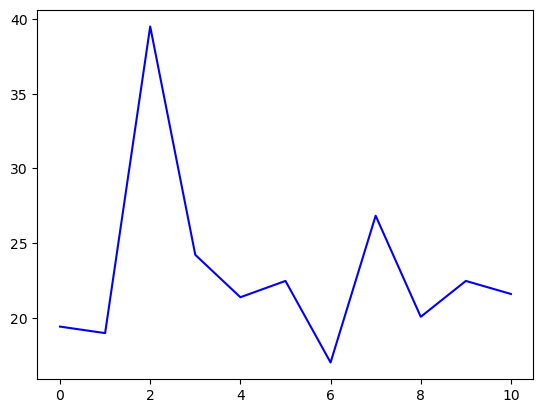

In [60]:
plt.plot([i for i in range(len(outputs))], outputs, "-b")

In [ ]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++(END)++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++